For manuscript CUC-WAG-PIN. Create graphs related to model

* Auxin profiles
* Noise tests (auxin profiles, position and amplitude of auxin peaks)

In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from skmisc.loess import loess
from scipy.signal import find_peaks
import datetime, warnings

%matplotlib inline
warnings.simplefilter(action='ignore')

In [400]:
data_to_use = 'cuc_noise' # auxin_noise / cuc_noise
r = 14 # rows to show in profile graphs


In [401]:
# Load data

if data_to_use == 'auxin_noise':
    # Setup - test auxin noise on pattern robustness
    s = 'b'
    noise_levels = [0, 2.5, 5, 7.5, 10, 12.5, 15]

    path_UTGeff_single = '../out_batch/MANUSCRIPT__v2_UTGeff/'
    path_UTGeff_multi =  '../out_batch/MANUSCRIPT__v2_UTGeff_noise_auxin/'

    UTGeff_single = pd.read_csv(path_UTGeff_single + 'auxin_profile_0_' + s + '.csv').head(r)

    data_UTGeff = [
        pd.read_csv(path_UTGeff_single + 'auxin_profile_0_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_2.5_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_5_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_7.5_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_10_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_12.5_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_15_' + s + '.csv')
    ]

    path_DUAL_single = '../out_batch/MANUSCRIPT__v2_DUAL/'
    path_DUAL_multi =  '../out_batch/MANUSCRIPT__v2_DUAL_noise_auxin/'

    DUAL_single = pd.read_csv(path_DUAL_single + 'auxin_profile_0_' + s + '.csv').head(r)

    data_DUAL = [
        pd.read_csv(path_DUAL_single + 'auxin_profile_0_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_2.5_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_5_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_7.5_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_10_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_12.5_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_15_' + s + '.csv')
    ]

if data_to_use == 'cuc_noise':
    # Setup - test CUC noise on pattern robustness
    s = 'a'
    noise_levels = [0, 5, 10, 15, 20, 25, 30]

    path_UTGeff_single = '../out_batch/MANUSCRIPT__v2_UTGeff/'
    path_UTGeff_multi = '../out_batch/MANUSCRIPT__v2_UTGeff_noise_CUC/'

    UTGeff_single = pd.read_csv(path_UTGeff_single + 'auxin_profile_0_' + s + '.csv').head(r)

    data_UTGeff = [
        pd.read_csv(path_UTGeff_single + 'auxin_profile_0_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_5_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_10_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_15_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_20_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_25_' + s + '.csv'),
        pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_30_' + s + '.csv')
    ]

    path_DUAL_single = '../out_batch/MANUSCRIPT__v2_DUAL/'
    path_DUAL_multi = '../out_batch/MANUSCRIPT__v2_DUAL_noise_CUC/'

    DUAL_single = pd.read_csv(path_DUAL_single + 'auxin_profile_0_' + s + '.csv').head(r)

    data_DUAL = [
        pd.read_csv(path_DUAL_single + 'auxin_profile_0_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_5_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_10_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_15_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_20_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_25_' + s + '.csv'),
        pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_30_' + s + '.csv')
    ]

In [402]:
# Process datasets UTGeff

# Select first X rows only (simpler options did not update dfs in list, see: https://stackoverflow.com/questions/49986865/modifying-dataframes-inside-a-list-is-not-working)
for i, df in enumerate(data_UTGeff): data_UTGeff[i] = df.head(r)

# Add key column indicating model
for i, df in enumerate(data_UTGeff): data_UTGeff[i]['model'] = 'UTGeff'

# Add key column indicating noise level
for i, df in enumerate(data_UTGeff): data_UTGeff[i]['noise'] = noise_levels[i]

# Give x values (cell row) to all datasets
data_x = np.linspace(1, len(data_UTGeff[0].index), len(data_UTGeff[0].index))
for i, df in enumerate(data_UTGeff): data_UTGeff[i]['x'] = data_x

# Calculate mean and median of profiles replicates
all_means_UTGeff = [i.drop(columns=['x']).mean(axis=1) for i in data_UTGeff[1:]]
all_medians_UTGeff = [i.drop(columns=['x']).median(axis=1) for i in data_UTGeff[1:]]

In [403]:
# Process datasets DUAL

# Select first X rows only (simpler options did not update dfs in list, see: https://stackoverflow.com/questions/49986865/modifying-dataframes-inside-a-list-is-not-working)
for i, df in enumerate(data_DUAL): data_DUAL[i] = df.head(r)

# Add key conlumn indicating model
for i, df in enumerate(data_DUAL): data_DUAL[i]['model'] = 'UTGeff'

# Add key column indicating noise level
for i, df in enumerate(data_DUAL): data_DUAL[i]['noise'] = noise_levels[i]

# Give x values (cell row) to all datasets
data_x = np.linspace(1, len(data_DUAL[0].index), len(data_DUAL[0].index))
for i, df in enumerate(data_DUAL): data_DUAL[i]['x'] = data_x

# Calculate mean and median of profiles replicates
all_means_DUAL = [i.drop(columns=['x']).mean(axis=1) for i in data_DUAL[1:]]
all_medians_DUAL = [i.drop(columns=['x']).median(axis=1) for i in data_DUAL[1:]]

data_DUAL[0]

,0,model,noise,x
0,253.432779,UTGeff,0,1.0
1,288.122586,UTGeff,0,2.0
2,142.751075,UTGeff,0,3.0
3,87.627763,UTGeff,0,4.0
4,63.372544,UTGeff,0,5.0
5,60.653305,UTGeff,0,6.0
6,78.778987,UTGeff,0,7.0
7,117.266119,UTGeff,0,8.0
8,173.875838,UTGeff,0,9.0
9,176.384394,UTGeff,0,10.0


In [404]:
# Make figure 2 (individual plots)

def make_individual_plot(sample1_single=None, sample2_single=None, sample_multi1=None, sample_multi2=None, mean=None, x=data_x, loess=None):

    fig, ax1 = plt.subplots(1,1, figsize=(2.5,4))

    ax1.plot(sample1_single['0'], sample1_single['x'], color='blue')
    ax1.plot(sample2_single['0'], sample2_single['x'], color='red')
    
    #for col in sample_multi.drop(columns=['x']):
        #ax1.plot(sample_multi[col], sample_multi['x'], color='blue', alpha=.15)

    #ax1.fill_betweenx(loess['x'], loess['ymin'], loess['ymax'], alpha=.2, color='blue', linewidth=0)

    #ax1.plot(mean, data_x, color='blue')

    ax1.set_xlim(-10,350) 
    ax1.set_yticks([1,4,7,10,13])
    ax1.invert_yaxis()
    plt.xlabel('[Auxin] (A.U.)')
    plt.ylabel('Cell row')
    #fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_comapre.png', bbox_inches='tight')
    #fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_compare.svg', bbox_inches='tight')
    timestamp = str(datetime.datetime.now())[:19].replace(':','-').replace(' ','_')
    #fig.savefig(timestamp +'.png', bbox_inches='tight', dpi=600)

    plt.show()

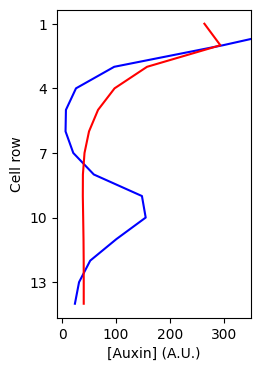

In [405]:
wt = pd.read_csv(path_UTGeff_single + 'auxin_profile_0_a.csv').head(r)
wt['x'] = data_x
cuc = pd.read_csv(path_UTGeff_single + 'auxin_profile_0_b.csv').head(r)
wt['x'], cuc['x'] = data_x, data_x

make_individual_plot(sample1_single=wt, sample2_single=cuc)

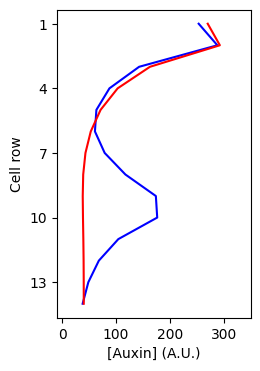

In [406]:
wt = pd.read_csv(path_DUAL_single + 'auxin_profile_0_a.csv').head(r)
wt['x'] = data_x
cuc = pd.read_csv(path_DUAL_single + 'auxin_profile_0_b.csv').head(r)
wt['x'], cuc['x'] = data_x, data_x

make_individual_plot(sample1_single=wt, sample2_single=cuc)

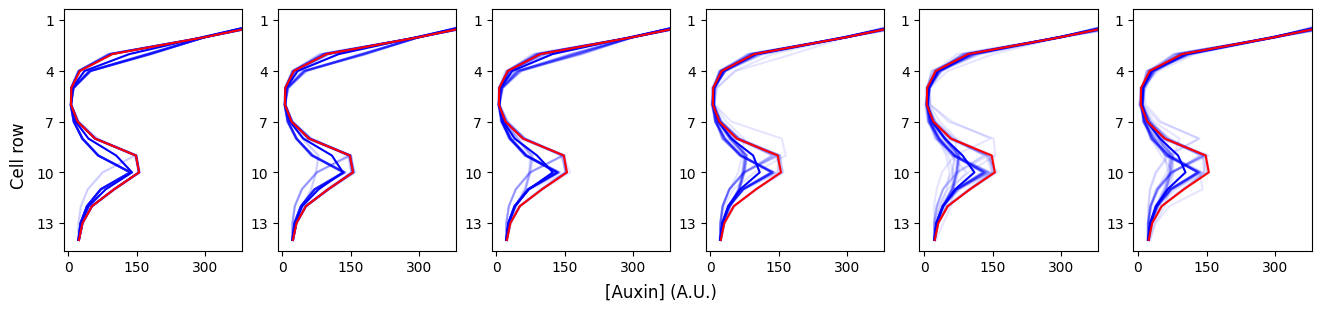

In [407]:
# Individual composite plot for UTGeff
fig3, axes = plt.subplots(1,len(noise_levels)-1, figsize=(0.5+len(noise_levels)*1.8,3), constrained_layout=True)
for data, ax in zip(data_UTGeff[1:], axes.ravel()):
    for col in data.drop(columns=['model', 'noise', 'x']):
        ax.plot(data[col], data['x'], color='blue', alpha=.1)
for mean, ax in zip(all_means_UTGeff, axes.ravel()):
    ax.plot(mean, data_x, color='blue')
for ax in axes.ravel():
    ax.plot(UTGeff_single['0'], data_x, color='red')
for ax in axes.ravel():    
    ax.set_yticks([1,4,7,10,13])
    ax.invert_yaxis()
    ax.set_xlim(-10,380)
    ax.set_xticks([0,150,300])   
fig3.supxlabel('[Auxin] (A.U.)')
fig3.supylabel('Cell row')
timestamp = str(datetime.datetime.now())[:19].replace(':','-').replace(' ','_')
#fig3.savefig(timestamp +'.svg', bbox_inches='tight', dpi=300)

plt.show()

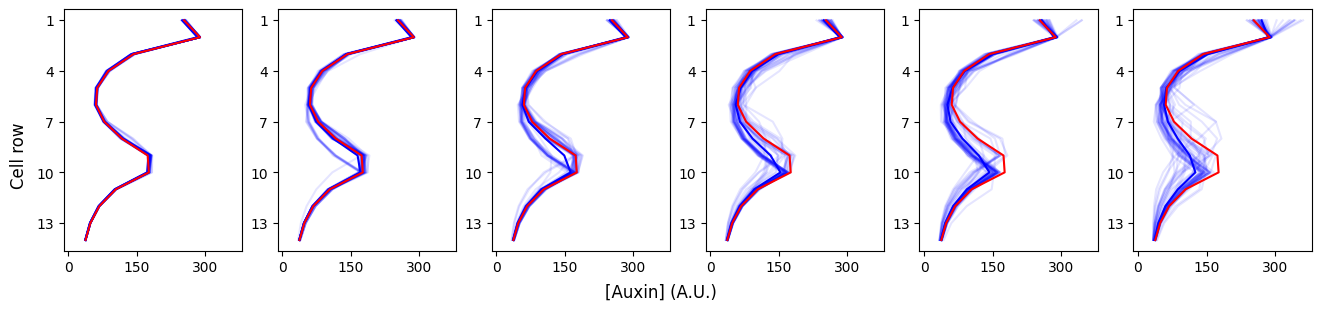

In [408]:
# Individual composite plot for DUAL

fig3, axes = plt.subplots(1,len(noise_levels)-1, figsize=(0.5+len(noise_levels)*1.8,3), constrained_layout=True)
for data, ax in zip(data_DUAL[1:], axes.ravel()):
    for col in data.drop(columns=['model', 'noise', 'x']):
        ax.plot(data[col], data['x'], color='blue', alpha=.1)
for mean, ax in zip(all_means_DUAL, axes.ravel()):
    ax.plot(mean, data_x, color='blue')
for ax in axes.ravel():
    ax.plot(DUAL_single['0'], data_x, color='red')
for ax in axes.ravel():    
    ax.set_yticks([1,4,7,10,13])
    ax.invert_yaxis()
    ax.set_xlim(-10,380)
    ax.set_xticks([0,150,300])
fig3.supxlabel('[Auxin] (A.U.)')
fig3.supylabel('Cell row')
#fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_comapre.png', bbox_inches='tight')
#fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_compare.svg', bbox_inches='tight')

plt.show()

In [409]:
# Characterize peaks UTGeff
# Iterate over samples and replicates and extract metrics from the emergent auxin site(s) that form(s) on the margin

def characterize_peaks(model, data):
    '''docstring'''

    # Define columns of dataframe that stores peak info
    all_peaks = pd.DataFrame(columns=['model', 'noise', 'sample', 'replica', 'pos', 'amplitude'])

    # Define columns of dataframe that stores % of samples with no peak
    pc_no_peaks = pd.DataFrame(columns=['model', 'noise', 'num_replicates', 'count_no_peaks', 'pc_no_peaks'])

    for sample_id, sample in enumerate(data):
        noise = noise_levels[sample_id]
        count_no_peak = 0
        num_replicates = sample.shape[1] - 3 # Subtract 3 because 3 columns of the df are x values and labels
        for replica in sample.drop(columns=['model', 'noise', 'x']):

            # Find pos and value of cell row with lowest auxin to calculate peak amplitude
            min_val = sample[replica].min()
            # Find peaks
            peaks = list(find_peaks(sample[replica], height=30, prominence=20))
            
            # Analyze peaks found

            if len(peaks[0]) == 0:
                count_no_peak += 1
                all_peaks = all_peaks.append(pd.DataFrame({'model': model, 'noise': noise, 'sample': sample_id, 'replica': replica, 'pos': np.nan, 'amplitude': 0}, index=[0]), ignore_index=True) # type: ignore
            
            if len(peaks[0]) == 1:
                #print(noise, peaks, sample[replica])
                peak_position = data[0]['x'][peaks[0][0]] #peak_pos = sample['x'][peaks[0][0]]
                peak_height = peaks[1]['peak_heights'][0]
                if peak_position < 4:
                    count_no_peak += 1
                else:
                    all_peaks = all_peaks.append(pd.DataFrame({'model': model, 'noise': noise, 'sample': sample_id, 'replica': replica, 'pos': float(peak_position), 'amplitude': peak_height - min_val}, index=[0]), ignore_index=True) # type: ignore
            
            if len(peaks[0]) > 1:
                # Select peak with highest amplitude, excluding the peak that represents the tip of the leaf (cell row)
                # If distal auxin site (rows 0, 1, 2, 3) is detected as peak, remove it from the list of peaks. 
                if peaks[0][0] < 4:
                    peaks[0] = np.delete(peaks[0], 0)
                    peaks[1]['peak_heights'] = np.delete(peaks[1]['peak_heights'], 0)
                # Select highest peak
                max_height_value = np.amax(peaks[1]['peak_heights'])
                max_height_index = np.argmax(peaks[1]['peak_heights'])
                peak_position = peaks[0][max_height_index]+1
                all_peaks = all_peaks.append(pd.DataFrame({'model': model, 'noise': noise, 'sample': sample_id, 'replica': replica, 'pos': float(peak_position), 'amplitude': max_height_value - min_val}, index=[0]), ignore_index=True) # type: ignore

                troughs = list(find_peaks(-sample[replica], height = 1, threshold = 1, distance = 1))
            
        pc_no_peaks = pc_no_peaks.append(pd.DataFrame({'model': model, 'noise': noise, 'num_replicates': num_replicates, 'count_no_peaks': count_no_peak, 'pc_no_peaks': 100*count_no_peak/num_replicates}, index=[0]), ignore_index=True) # type: ignore

    return [all_peaks, pc_no_peaks]

In [410]:
peaks_UTGeff, pc_no_peaks_UTGeff = characterize_peaks('UTGeff', data_UTGeff)
peaks_UTGeff

,model,noise,sample,replica,pos,amplitude
0,UTGeff,0,0,0,10.0,148.913282
1,UTGeff,5,1,0,10.0,130.784289
2,UTGeff,5,1,1,10.0,150.149417
3,UTGeff,5,1,2,10.0,149.202669
4,UTGeff,5,1,3,10.0,130.451368
...,...,...,...,...,...,...
296,UTGeff,30,6,45,9.0,139.953703
297,UTGeff,30,6,46,10.0,126.394387
298,UTGeff,30,6,47,10.0,59.956010
299,UTGeff,30,6,48,10.0,123.886753


In [411]:
pc_no_peaks_UTGeff

,model,noise,num_replicates,count_no_peaks,pc_no_peaks
0,UTGeff,0,1,0,0.0
1,UTGeff,5,50,0,0.0
2,UTGeff,10,50,0,0.0
3,UTGeff,15,50,0,0.0
4,UTGeff,20,50,0,0.0
5,UTGeff,25,50,0,0.0
6,UTGeff,30,50,0,0.0


In [412]:
peaks_DUAL, pc_no_peaks_DUAL = characterize_peaks('DUAL', data_DUAL)
peaks_DUAL

,model,noise,sample,replica,pos,amplitude
0,DUAL,0,0,0,10.0,138.572561
1,DUAL,5,1,0,9.0,139.654966
2,DUAL,5,1,1,9.0,144.131740
3,DUAL,5,1,2,9.0,143.294645
4,DUAL,5,1,3,10.0,145.737371
...,...,...,...,...,...,...
296,DUAL,30,6,45,9.0,68.239623
297,DUAL,30,6,46,7.0,137.505741
298,DUAL,30,6,47,9.0,123.483404
299,DUAL,30,6,48,9.0,124.776126


In [413]:
pc_no_peaks_DUAL

,model,noise,num_replicates,count_no_peaks,pc_no_peaks
0,DUAL,0,1,0,0.0
1,DUAL,5,50,0,0.0
2,DUAL,10,50,0,0.0
3,DUAL,15,50,0,0.0
4,DUAL,20,50,0,0.0
5,DUAL,25,50,0,0.0
6,DUAL,30,50,0,0.0


In [414]:
peaks_all = pd.concat([peaks_UTGeff, peaks_DUAL])

In [415]:
'''# Graph amplitude of peaks both models together

fig4, ax = plt.subplots(1,1, figsize=(10,4))
ax.set_ylim(0, 250)
sns.violinplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, alpha=0.3, linewidth=0, color=(.9, .9, .9))
sns.pointplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, ci='sd', linewidth=0, capsize=0, join=False, color='gray', scale=1, errwidth=2)
sns.swarmplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, alpha=0.3, color='blue', size=4)
ax.set_ylabel('Amplitude of emergent auxin peak')
ax.set_xlabel('Noise amplitude in [Auxin] (%)')
ax.set_xticklabels(noise_levels)
ax.get_legend().remove()
plt.show()'''

"# Graph amplitude of peaks both models together\n\nfig4, ax = plt.subplots(1,1, figsize=(10,4))\nax.set_ylim(0, 250)\nsns.violinplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, alpha=0.3, linewidth=0, color=(.9, .9, .9))\nsns.pointplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, ci='sd', linewidth=0, capsize=0, join=False, color='gray', scale=1, errwidth=2)\nsns.swarmplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, alpha=0.3, color='blue', size=4)\nax.set_ylabel('Amplitude of emergent auxin peak')\nax.set_xlabel('Noise amplitude in [Auxin] (%)')\nax.set_xticklabels(noise_levels)\nax.get_legend().remove()\nplt.show()"

In [428]:
# Graph amplitude of peaks

def plot_amplitude_single_model(data, noise_levels):
    fig4, ax = plt.subplots(1,1, figsize=(5,4))
    ax.set_ylim(-5, 250)
    #sns.violinplot(data=data, x='sample', y=data.amplitude, alpha=0.3, size=3, linewidth=0, color=(.9, .9, .9))
    sns.swarmplot(data=data, x='sample', y=data.amplitude, alpha=0.5, color='blue', size=3)
    sns.pointplot(data=data, x='sample', y=data.amplitude, ci='sd', linewidth=0, capsize=.5, join=False, color='gray', scale=.5, errwidth=2.5)
    ax.set_ylabel('Amplitude of emergent auxin peak')
    if data_to_use == 'auxin_noise': element_in_legend = '[Auxin]'
    if data_to_use == 'cuc_noise': element_in_legend = '[CUC]'
    ax.set_xlabel('Noise amplitude in ' + element_in_legend + ' (%)')
    ax.set_xticklabels(noise_levels)
    plt.show()

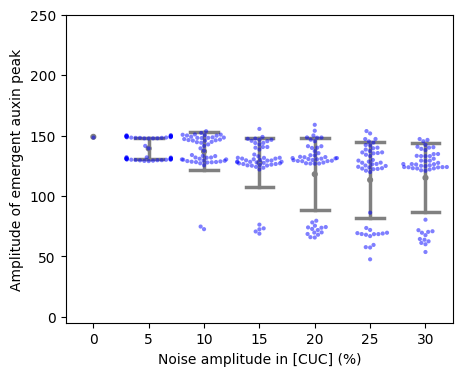

In [429]:
plot_amplitude_single_model(peaks_UTGeff, noise_levels)

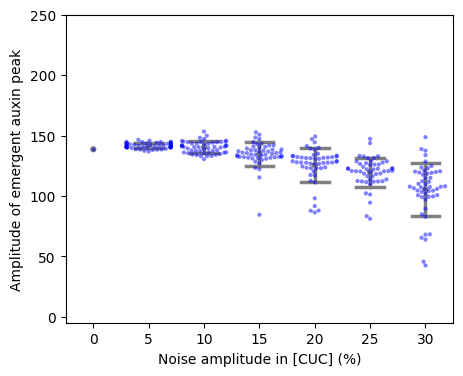

In [430]:
plot_amplitude_single_model(peaks_DUAL, noise_levels)

In [431]:
# Graph % of no peaks

def plot_pcnopeaks_single_model(data, noise_levels):
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.set_ylim(0, 100)
    sns.barplot(data=data, x='noise', y='pc_no_peaks', hue='model')
    ax.set_ylabel('Frequency absence of peaks (%)')
    ax.set_xlabel('Noise amplitude in [Auxin] (%)')
    ax.set_xticklabels(noise_levels)
    ax.get_legend().set_visible(False)
    plt.show()

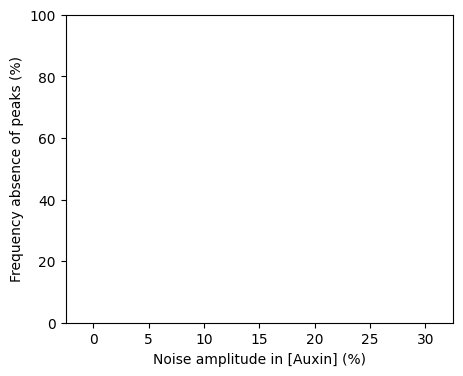

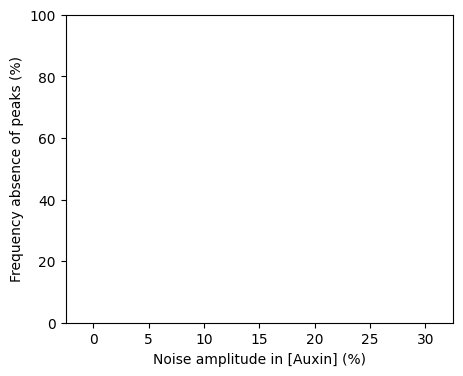

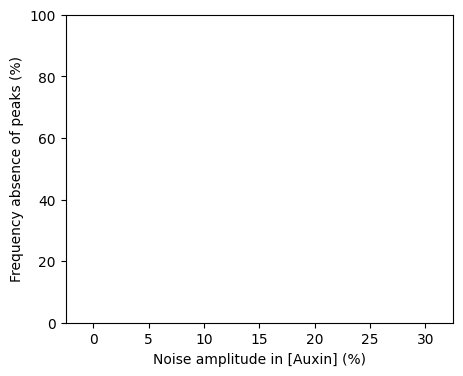

In [432]:
pc_no_peaks_all = pd.concat([pc_no_peaks_UTGeff, pc_no_peaks_DUAL])
plot_pcnopeaks_single_model(pc_no_peaks_UTGeff, noise_levels[:9])
plot_pcnopeaks_single_model(pc_no_peaks_DUAL, noise_levels[:9])
plot_pcnopeaks_single_model(pc_no_peaks_all, noise_levels[:9])

In [436]:
# Graph position of peaks

def plot_position_single_model(data, noise_levels):
    fig4, ax = plt.subplots(1,1, figsize=(5,4))
    ax.set_ylim(.5, 14.5)
    ax.invert_yaxis()
    #sns.violinplot(data=data, x='sample', y=data.pos, alpha=0.3, size=3, linewidth=0, color=(.9, .9, .9))
    sns.stripplot(data=data, x='sample', y=data.pos, alpha=0.3, color='blue', size=3, jitter=.4)
    sns.pointplot(data=data, x='sample', y=data.pos, ci='sd', linewidth=0, capsize=.5, join=False, color='gray', scale=.5, errwidth=2.5)
    ax.set_ylabel('Position (cell row) of emergent auxin peak')
    if data_to_use == 'auxin_noise': element_in_legend = '[Auxin]'
    if data_to_use == 'cuc_noise': element_in_legend = '[CUC]'
    ax.set_xlabel('Noise amplitude in ' + element_in_legend + ' (%)')
    ax.set_xticklabels(noise_levels)
    plt.show()

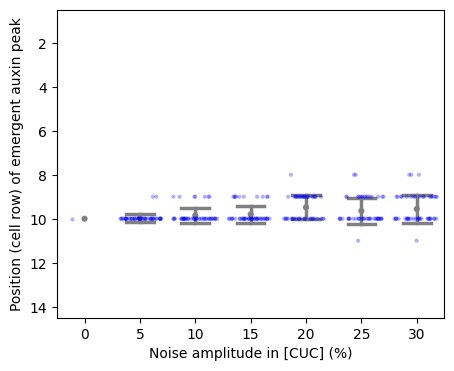

In [437]:
peaks_UTGeff_notNaN = peaks_UTGeff.dropna(subset=['pos'])
plot_position_single_model(peaks_UTGeff_notNaN, noise_levels)

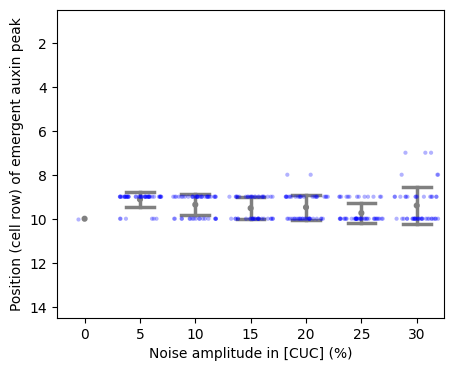

In [438]:
peaks_DUAL_notNaN = peaks_DUAL.dropna(subset=['pos'])
plot_position_single_model(peaks_DUAL_notNaN, noise_levels)